<a href="https://colab.research.google.com/github/multikokoiti1998/vgg_8_3/blob/Resnet/ResNet101.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
!pip install albumentations

In [28]:
import matplotlib.pyplot as plt
import numpy as np
import copy
import time
import os
from tqdm import tqdm
import random
import torchvision.transforms as transforms
from torchvision import datasets, transforms
import torchvision.models as models
import torchvision
from PIL import Image
import torch.nn as nn
import torch
import pandas as pd
from sklearn.model_selection import KFold,train_test_split,StratifiedKFold
from torch.utils.data import DataLoader, Subset
from torchvision import transforms
from torch.utils.data import Dataset
from pathlib import Path
from typing import List, Tuple
from pathlib import Path
import xml.etree.ElementTree as ET
import torchvision.models as models
import torch.optim as optim
import albumentations as A
from sklearn.metrics import classification_report

In [29]:
# 画像ディレクトリと画像パスの取得
image_directory = '/content/drive/MyDrive/lernig/obiref88/image'
label_directory = '/content/drive/MyDrive/lernig/obiref88/label'

def update_xml_paths(image_directory: str, label_directory: str):
    image_paths = []
    labels = []

    # 画像ファイルとXMLファイルの一致確認
    for image_file in os.listdir(image_directory):
        if image_file.endswith('.jpg'):
            base_name = image_file.replace('.jpg', '')

            xml_path = Path(label_directory) / f"{base_name}.xml"

            if xml_path.exists():
                tree = ET.parse(xml_path)
                root = tree.getroot()
                label = root.find('.//name')
                image_paths.append(os.path.join(image_directory, image_file))
                labels.append(label.text)

    return image_paths, labels

image_paths, labels = update_xml_paths(image_directory, label_directory)
print("Number of image paths:", len(image_paths))
print("Number of labels:", len(labels))


Number of image paths: 300
Number of labels: 300


In [30]:
data_transform = {
    'train': transforms.Compose(
        [transforms.Resize((256, 256)),
         transforms.CenterCrop(224),
         transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
         transforms.RandomRotation(degrees=[-5, 5]),
         transforms.ColorJitter(brightness=0.3, contrast=0.5),
         #A.GaussNoise(var_limit=(10, 50))transformライブラリでないので変換前後で定義しなおさなくてはならない,
         transforms.ToTensor(),
         transforms.Normalize(mean=[0.35187622, 0.35187622, 0.35187622],
                              std=[0.33888655, 0.33888655, 0.33888655]),
         ]),
    'val': transforms.Compose(
        [transforms.Resize((256, 256)),
         transforms.CenterCrop(224),
         transforms.ToTensor(),
         transforms.Normalize(mean=[0.35187622, 0.35187622, 0.35187622],
                              std=[0.33888655, 0.33888655, 0.33888655]),
         ])
}



In [31]:
label_mapping = {
    'ok': 0,
    'out': 1
}
class ImageDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = [label_mapping[label] for label in labels]
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        image = Image.open(self.image_paths[index]).convert('RGB')
        label = self.labels[index]
        if self.transform:
            image = self.transform(image)
            label=torch.tensor(label)
        return image, label


In [32]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [33]:
num_epochs=200
train_losses = []
val_losses = []
train_accs = []
val_accs = []
train_dataset=[]
val_dataset=[]
total_train_accs=[]
total_val_accs=[]
data_size = {'train': len(train_dataset), 'val': len(val_dataset)}

In [34]:
def train_model(model, criterion, optimizer, num_epochs):

        for epoch in range(num_epochs):
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()
                else:
                    model.eval()

                running_loss = 0.0
                corrects = 0

                for inputs, labels in dataloaders[phase]:
                    inputs, labels = inputs.to(device), labels.to(device)

                    optimizer.zero_grad()

                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    running_loss += loss.item() * inputs.size(0)
                    _, preds = torch.max(outputs, 1)
                    corrects += torch.sum(preds == labels.data)

                epoch_loss = running_loss / data_size[phase]
                epoch_acc = corrects.double() / data_size[phase]

                if phase == 'train':
                    train_losses.append(epoch_loss)
                    train_accs.append(epoch_acc)
                    print('{}Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
                else:
                    val_losses.append(epoch_loss)
                    val_accs.append(epoch_acc)
                    print('{}Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

              #print('{}Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

        train_accs_cpu = [acc.cpu().numpy() for acc in train_accs]
        val_accs_cpu = [acc.cpu().numpy() for acc in val_accs]

        plot_training_history(train_losses, val_losses, train_accs_cpu, val_accs_cpu)



def plot_training_history(train_losses, val_losses, train_accs, val_accs):
    epochs = range(1, len(train_losses) + 1)

    # Lossのプロット
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'bo-', label='Training Loss')
    plt.plot(epochs, val_losses, 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracyのプロット
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accs, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_accs, 'ro-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.ylim(0.4, 1)
    plt.tight_layout()
    plt.show()


In [35]:
net = models.resnet101(pretrained=True)

#for param in net.parameters():
          #param.requires_grad = False

# モデルをGPUに移動

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = net.to(device)

# 損失関数と最適化アルゴリズムを定義(MSE）
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001)
#optimizer = optim.Adam(net.parameters(), lr=0.001)
# モデルのトレーニングと評価
model = net
base_path = r'/content/drive/MyDrive/learning'
folder_name = 'weight'
directory_path = os.path.join(base_path, folder_name)
file_name = 'alexnet.pth'
file_path = os.path.join(base_path, folder_name, file_name)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth
100%|██████████| 171M/171M [00:00<00:00, 201MB/s]


In [36]:
print("Length of image_paths:", len(image_paths))
print("Length of labels:", len(labels))

Length of image_paths: 300
Length of labels: 300


==========Cross Validation Fold 1==========
trainLoss: 0.9756 Acc: 0.2542
valLoss: 0.9343 Acc: 0.2167
trainLoss: 0.9709 Acc: 0.2542
valLoss: 0.8639 Acc: 0.2167
trainLoss: 0.9737 Acc: 0.2542
valLoss: 0.7702 Acc: 0.2333
trainLoss: 0.9517 Acc: 0.2542
valLoss: 0.7861 Acc: 0.2500
trainLoss: 0.9469 Acc: 0.2542
valLoss: 0.7814 Acc: 0.2333
trainLoss: 0.9271 Acc: 0.2542
valLoss: 0.8059 Acc: 0.2167
trainLoss: 0.9374 Acc: 0.2542
valLoss: 0.8365 Acc: 0.2167
trainLoss: 0.9233 Acc: 0.2542
valLoss: 0.8445 Acc: 0.2333
trainLoss: 0.9111 Acc: 0.2542
valLoss: 0.9662 Acc: 0.2167
trainLoss: 0.9060 Acc: 0.2542
valLoss: 0.9225 Acc: 0.2167
trainLoss: 0.9073 Acc: 0.2583
valLoss: 0.8204 Acc: 0.2333
trainLoss: 0.9055 Acc: 0.2542
valLoss: 0.8411 Acc: 0.2167
trainLoss: 0.8933 Acc: 0.2542
valLoss: 0.8297 Acc: 0.2167
trainLoss: 0.8873 Acc: 0.2542
valLoss: 0.8664 Acc: 0.2167
trainLoss: 0.8878 Acc: 0.2625
valLoss: 0.8844 Acc: 0.2167
trainLoss: 0.8762 Acc: 0.2542
valLoss: 0.8532 Acc: 0.2500
trainLoss: 0.8707 Acc: 0.262

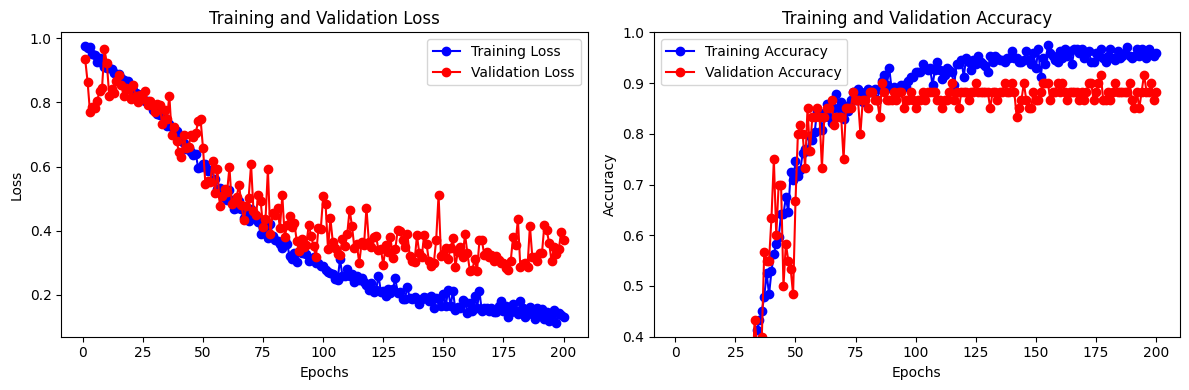

Train done.
Train saved.
              precision    recall  f1-score   support

          ok       0.92      0.94      0.93        47
         out       0.75      0.69      0.72        13

    accuracy                           0.88        60
   macro avg       0.83      0.81      0.82        60
weighted avg       0.88      0.88      0.88        60

==========Cross Validation Fold 2==========
trainLoss: 0.7195 Acc: 0.3542
valLoss: 0.7599 Acc: 0.2000
trainLoss: 0.6561 Acc: 0.4875
valLoss: 0.6915 Acc: 0.2333
trainLoss: 0.5851 Acc: 0.7542
valLoss: 0.6418 Acc: 0.4667
trainLoss: 0.5378 Acc: 0.8750
valLoss: 0.5671 Acc: 0.8833
trainLoss: 0.5086 Acc: 0.9083
valLoss: 0.5086 Acc: 1.0000
trainLoss: 0.4660 Acc: 0.9167
valLoss: 0.4655 Acc: 1.0000
trainLoss: 0.4465 Acc: 0.9375
valLoss: 0.4306 Acc: 1.0000
trainLoss: 0.4378 Acc: 0.9333
valLoss: 0.4047 Acc: 1.0000
trainLoss: 0.4152 Acc: 0.9333
valLoss: 0.3801 Acc: 1.0000
trainLoss: 0.3731 Acc: 0.9542
valLoss: 0.3566 Acc: 1.0000
trainLoss: 0.3756 Acc: 0

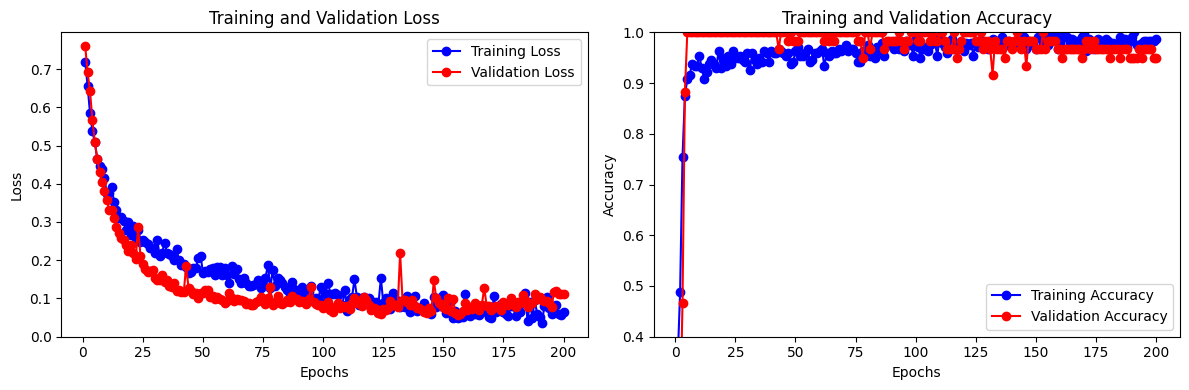

Train done.
Train saved.
              precision    recall  f1-score   support

          ok       0.96      0.98      0.97        48
         out       0.91      0.83      0.87        12

    accuracy                           0.95        60
   macro avg       0.93      0.91      0.92        60
weighted avg       0.95      0.95      0.95        60

==========Cross Validation Fold 3==========
trainLoss: 0.5892 Acc: 0.9292
valLoss: 0.5547 Acc: 0.9167
trainLoss: 0.5014 Acc: 0.9708
valLoss: 0.4822 Acc: 0.9833
trainLoss: 0.4249 Acc: 0.9750
valLoss: 0.4116 Acc: 0.9833
trainLoss: 0.3879 Acc: 0.9792
valLoss: 0.3660 Acc: 0.9833
trainLoss: 0.3541 Acc: 0.9625
valLoss: 0.3257 Acc: 0.9833
trainLoss: 0.3215 Acc: 0.9750
valLoss: 0.2934 Acc: 0.9833
trainLoss: 0.3026 Acc: 0.9667
valLoss: 0.2620 Acc: 0.9833
trainLoss: 0.2694 Acc: 0.9917
valLoss: 0.2414 Acc: 0.9833
trainLoss: 0.2547 Acc: 0.9792
valLoss: 0.2378 Acc: 0.9833
trainLoss: 0.2363 Acc: 0.9958
valLoss: 0.2139 Acc: 0.9833
trainLoss: 0.2096 Acc: 0

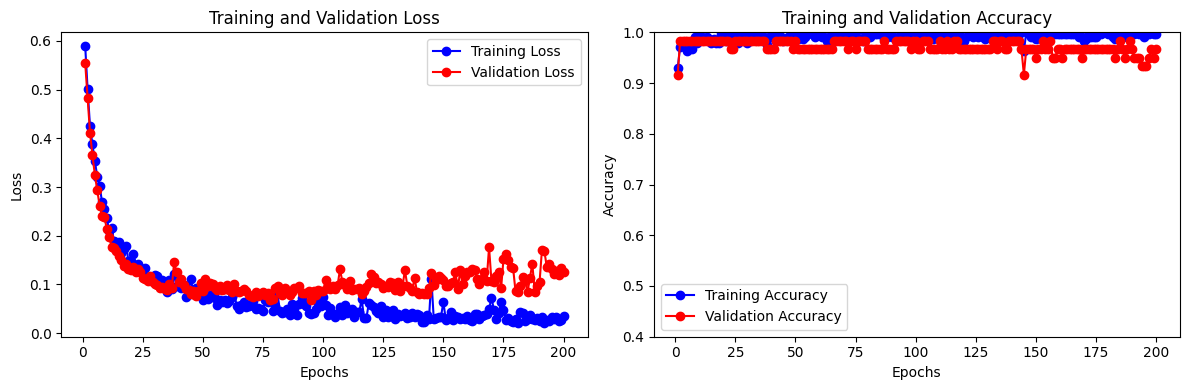

Train done.
Train saved.
              precision    recall  f1-score   support

          ok       1.00      0.95      0.98        42
         out       0.90      1.00      0.95        18

    accuracy                           0.97        60
   macro avg       0.95      0.98      0.96        60
weighted avg       0.97      0.97      0.97        60

==========Cross Validation Fold 4==========
trainLoss: 0.6153 Acc: 0.7583
valLoss: 0.5326 Acc: 1.0000
trainLoss: 0.4851 Acc: 0.9542
valLoss: 0.4396 Acc: 1.0000
trainLoss: 0.4031 Acc: 0.9833
valLoss: 0.3673 Acc: 1.0000
trainLoss: 0.3478 Acc: 0.9875
valLoss: 0.3087 Acc: 1.0000
trainLoss: 0.3124 Acc: 0.9833
valLoss: 0.2715 Acc: 1.0000
trainLoss: 0.2729 Acc: 0.9792
valLoss: 0.2479 Acc: 1.0000
trainLoss: 0.2646 Acc: 0.9625
valLoss: 0.2207 Acc: 1.0000
trainLoss: 0.2276 Acc: 0.9875
valLoss: 0.1999 Acc: 1.0000
trainLoss: 0.2149 Acc: 0.9833
valLoss: 0.1800 Acc: 1.0000
trainLoss: 0.2050 Acc: 0.9792
valLoss: 0.1621 Acc: 1.0000
trainLoss: 0.1916 Acc: 0

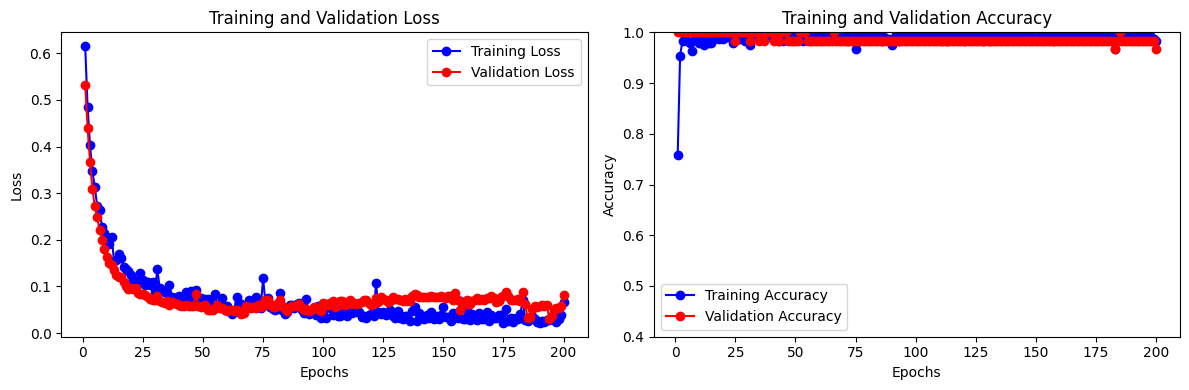

Train done.
Train saved.
              precision    recall  f1-score   support

          ok       0.96      1.00      0.98        44
         out       1.00      0.88      0.93        16

    accuracy                           0.97        60
   macro avg       0.98      0.94      0.96        60
weighted avg       0.97      0.97      0.97        60

==========Cross Validation Fold 5==========
trainLoss: 0.7471 Acc: 0.2500
valLoss: 0.7094 Acc: 0.2500
trainLoss: 0.6114 Acc: 0.5542
valLoss: 0.6152 Acc: 0.2833
trainLoss: 0.5069 Acc: 0.9417
valLoss: 0.5246 Acc: 0.9833
trainLoss: 0.4415 Acc: 0.9583
valLoss: 0.4433 Acc: 1.0000
trainLoss: 0.3595 Acc: 0.9875
valLoss: 0.3695 Acc: 1.0000
trainLoss: 0.3244 Acc: 0.9875
valLoss: 0.3332 Acc: 1.0000
trainLoss: 0.2781 Acc: 0.9958
valLoss: 0.2795 Acc: 1.0000
trainLoss: 0.2618 Acc: 0.9833
valLoss: 0.2452 Acc: 1.0000
trainLoss: 0.2287 Acc: 0.9875
valLoss: 0.2212 Acc: 1.0000
trainLoss: 0.2079 Acc: 0.9958
valLoss: 0.1989 Acc: 1.0000
trainLoss: 0.2083 Acc: 0

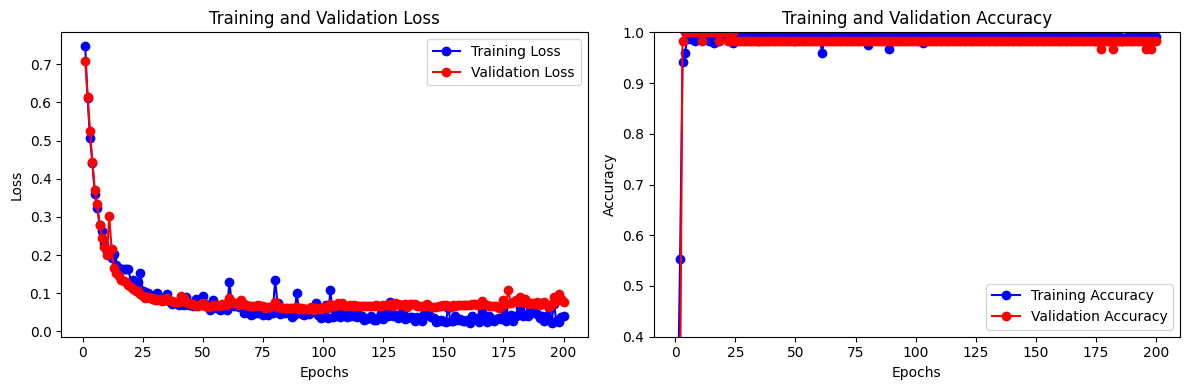

Train done.
Train saved.
              precision    recall  f1-score   support

          ok       0.98      1.00      0.99        45
         out       1.00      0.93      0.97        15

    accuracy                           0.98        60
   macro avg       0.99      0.97      0.98        60
weighted avg       0.98      0.98      0.98        60



In [37]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# データセットの分割とデータローダーの作成
for fold, (train_index, val_index) in enumerate(kfold.split(image_paths,labels), 1):
    print(f'==========Cross Validation Fold {fold}==========')
    image_directory = '/content/drive/MyDrive/lernig/OBI_ref/image'
    label_directory = '/content/drive/MyDrive/lernig/OBI_ref/label'


    image_paths, labels = update_xml_paths(image_directory, label_directory)
    train_paths = [image_paths[i] for i in train_index]
    train_labels = [labels[i] for i in train_index]
    val_paths = [image_paths[i] for i in val_index]
    val_labels = [labels[i] for i in val_index]

    train_dataset = ImageDataset(train_paths, train_labels, transform=data_transform['train'])
    val_dataset = ImageDataset(val_paths, val_labels, transform=data_transform['val'])

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    dataloaders  = {"train":train_loader, "val":val_loader}

    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    # 事前学習済みモデルの全結合層の出力ユニット数をデータのクラス数に置き換え
    num_classes = len(set(train_labels))
    net.fc = nn.Linear(net.fc.in_features, num_classes)

# ここでデータローダーを使用して学習や検証を行う
    data_size = {'train': len(train_dataset), 'val': len(val_dataset)}
    train_model(model, criterion, optimizer, num_epochs)
    print('Train done.')
    file_path = os.path.join(directory_path, f'{file_name}_{str(fold)}.pth')
    # モデルの保存
    torch.save(model.state_dict(), file_path)
    print('Train saved.')
    model.load_state_dict(torch.load(file_path))
    model.eval()
    model.to(device)

    y_pred = []
    y_true = []
    with torch.no_grad():
      for images, labels in val_loader:
          images = images.to(device)
          labels = labels.to(device)
          outputs = model(images)
          _, predicted = torch.max(outputs.data, 1)
          y_pred.extend(predicted.cpu().numpy())
          y_true.extend(labels.cpu().numpy())

    # 評価
    target_names = ['ok', 'out']  # クラス名をリストで指定
    print(classification_report(y_true, y_pred, target_names=target_names))